In [2]:
import os
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import folium
from PIL import Image
from folium.plugins import FloatImage
import base64

In [3]:
# Path to the netCDF data
data_path = "/work/pi_mzink_umass_edu/SPRITE/skillful_nowcasting/netCDFData/train/20180908/20180908_151848.nc"

# Open the netCDF file and extract data
nc = Dataset(data_path, "r")
data = np.array(nc.variables["RRdata"][:])  # Replace with the correct variable name if different
x_coords = np.array(nc.variables["x0"][:])  # Read x-coordinates
y_coords = np.array(nc.variables["y0"][:])  # Read y-coordinates
nc.close()

In [4]:
# Create custom colormap
class ColormapConfig:
    def __init__(self):
        self.cmap = None
        self.norm = None
        self.clevs = None
        self.bounds = None

        self.build_colormap()

    def build_colormap(self):
        # Shortened version of Eric's custom colormap
        color_list = ["skyblue", "blue", "navy", "yellow", "orange", "green", "brown", "red"]
        self.clevs = [0.1, 2, 5, 9, 15, 32, 64, 128]  # Precipitation intensity levels
        self.bounds = [0.1, 2, 5, 9, 15, 32, 64, 128]  #

        self.cmap = mcolors.ListedColormap(color_list)
        self.cmap.set_over("red")
        self.cmap.set_under("none")
        self.cmap.set_bad("gray", alpha=0.5)
        self.norm = mcolors.BoundaryNorm(self.clevs, self.cmap.N)
        self.cmap.name = "Custom Colormap"


cmap_config = ColormapConfig()

In [5]:
# Names and paths
overlay_image_name = "overlay_image.png"
colorbar_filename = "colorbar.png"
html_filename = "NetCDF_Map.html"
output_folder = "./file1"  # Change this if you want to save to a different directory

os.makedirs(output_folder, exist_ok=True)

In [6]:
def create_colorbar(cmap_config, filename="colorbar.png", orientation="vertical"):
    cmap = cmap_config.cmap
    norm = cmap_config.norm
    clevs = cmap_config.clevs
    bounds = cmap_config.bounds

    # Adjust the figure size and colorbar axis to create white space and a thinner colorbar
    fig, ax = plt.subplots(figsize=(0.4, 8)) if orientation == "vertical" else plt.subplots(figsize=(8, 0.4))
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cb = plt.colorbar(
        sm,
        cax=ax,
        orientation=orientation,
        boundaries=clevs,
        ticks=bounds,
        extend="max",
        pad=0.05,  # Add padding between the colorbar and the main image
    )
    cb.set_label("Precipitation intensity [mm/h]", size=13)

    for t in cb.ax.get_yticklabels():
        t.set_fontsize(12)

    fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.2)  # Add white space around colorbar
    plt.close(fig)
    return filename


def resize_image(input_path, output_path, size=(100, 500)):
    with Image.open(input_path) as img:
        resized_img = img.resize(size, Image.Resampling.LANCZOS)
        resized_img.save(output_path)
        return output_path


def create_colored_overlay(data_slice, cmap_config, filename="overlay_image.png"):
    cmap = cmap_config.cmap
    norm = cmap_config.norm
    rgba_image = cmap(norm(data_slice))
    rgba_image = np.flipud(rgba_image)
    rgba_image = (rgba_image * 255).astype(np.uint8)
    image = Image.fromarray(rgba_image, mode="RGBA")
    image.save(filename)
    return filename

In [7]:
# Get the minimum and maximum values of x and y
x_min = float(x_coords.min())
x_max = float(x_coords.max())
y_min = float(y_coords.min())
y_max = float(y_coords.max())

# Calculate the center of the map
center_lat = (y_min + y_max) / 2
center_lon = (x_min + x_max) / 2

# Create the map
m = folium.Map(location=[center_lat, center_lon], zoom_start=9)

# Create and save the overlay image
overlay_image_path = os.path.join(output_folder, overlay_image_name)
overlay_image_path = create_colored_overlay(data[0, :, :], cmap_config, filename=overlay_image_path)

# Add the overlay to the map
folium.raster_layers.ImageOverlay(
    image=overlay_image_path,
    bounds=[[y_min, x_min], [y_max, x_max]],
    opacity=0.6,
    interactive=True,
    cross_origin=False,
    zindex=1,
).add_to(m)

# Create and save the colorbar image
colorbar_path = os.path.join(output_folder, colorbar_filename)
colorbar_path = create_colorbar(cmap_config, filename=colorbar_path, orientation="vertical")
resized_colorbar_path = os.path.join(output_folder, "colorbar_resized.png")
resized_colorbar_path = resize_image(colorbar_path, resized_colorbar_path, size=(100, 500))

with open(resized_colorbar_path, "rb") as colorbar_file:
    b64_content = base64.b64encode(colorbar_file.read()).decode("utf-8")

# Add the colorbar to the map
encoded_colorbar = "data:image/png;base64,{}".format(b64_content)
FloatImage(encoded_colorbar, bottom=5, left=90).add_to(m)

# Additional map configurations
folium.LayerControl().add_to(m)
m.add_child(folium.LatLngPopup())

# Draw a bounding box around the data
bbox = [[y_min, x_min], [y_max, x_max]]
folium.Rectangle(bounds=bbox, color="black", weight=2, fill=False).add_to(m)

# Save the map
html_filepath = os.path.join(output_folder, html_filename)
m.save(html_filepath)  # Save as an HTML file

# If running in a Jupyter notebook, display the map
# m


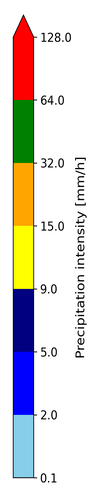
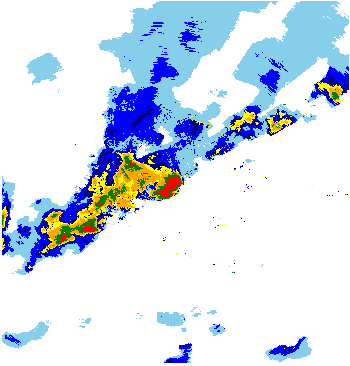

In [8]:
m